_Lambda School Data Science, Unit 2_

# Applied Modeling Sprint Challenge: Predict Chicago food inspections 🍕

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to install packages in Colab:

In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:

- Confusion Matrix
- Permutation Importances
- Partial Dependence Plot, 1 feature isolation
- Partial Dependence Plot, 2 features interaction
- Shapley Values

_To earn a score of 3 for this part, make four of these visualization types._

## Part 1: Preprocessing

> You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

In [86]:
#explore the data

train.head()


,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


In [87]:
train.describe()

,Inspection ID,License #,Zip,Latitude,Longitude,Fail
count,5.191600e+04,5.191100e+04,51890.000000,51718.000000,51718.000000,51916.000000
mean,1.330265e+06,1.549491e+06,60628.834669,41.879568,-87.676663,0.258610
std,6.202664e+05,9.018283e+05,22.736963,0.081126,0.059509,0.437875
min,4.425000e+04,0.000000e+00,60007.000000,41.644670,-87.914428,0.000000
25%,6.796205e+05,1.140745e+06,60614.000000,41.830296,-87.707857,0.000000
50%,1.424226e+06,1.958619e+06,60625.000000,41.890166,-87.666524,0.000000
75%,1.946952e+06,2.215507e+06,60643.000000,41.939167,-87.634461,1.000000
max,2.279709e+06,8.700606e+06,60827.000000,42.021064,-87.525094,1.000000


In [88]:
train.isna().sum()

Inspection ID         0
DBA Name              0
AKA Name            623
License #             5
Facility Type       224
Risk                 12
Address               0
City                 53
State                10
Zip                  26
Inspection Date       0
Inspection Type       1
Violations         9655
Latitude            198
Longitude           198
Location            198
Fail                  0
dtype: int64

In [89]:
#replaces nan's with 'unknown'
train = train.fillna('unknown')
test = test.fillna('unknown')
train.isna().sum(), test.isna().sum()

(Inspection ID      0
 DBA Name           0
 AKA Name           0
 License #          0
 Facility Type      0
 Risk               0
 Address            0
 City               0
 State              0
 Zip                0
 Inspection Date    0
 Inspection Type    0
 Violations         0
 Latitude           0
 Longitude          0
 Location           0
 Fail               0
 dtype: int64, Inspection ID      0
 DBA Name           0
 AKA Name           0
 License #          0
 Facility Type      0
 Risk               0
 Address            0
 City               0
 State              0
 Zip                0
 Inspection Date    0
 Inspection Type    0
 Violations         0
 Latitude           0
 Longitude          0
 Location           0
 Fail               0
 dtype: int64)

In [90]:
cardinality = train.select_dtypes(exclude='number').nunique()
high_cardinality_feat = cardinality[cardinality > 100].index.tolist()
high_cardinality_feat

['DBA Name',
 'AKA Name',
 'License #',
 'Facility Type',
 'Address',
 'Inspection Date',
 'Violations',
 'Latitude',
 'Longitude',
 'Location']

In [0]:
#drop features that may cause leakage or aren't needed
drop_features = ['AKA Name', 'Location', 'Address', 'License #']
train = train.drop(columns=drop_features)

In [92]:
test = test.drop(columns=drop_features)
test.shape

(17306, 13)

In [93]:
train = train.drop(columns='Inspection ID')
test = test.drop(columns = 'Inspection ID')
train.shape, test.shape

((51916, 12), (17306, 12))

To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections.

## Part 2: Modeling

> **Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.
>
> Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

In [94]:
import numpy as np
from sklearn.model_selection import train_test_split

train, val = train_test_split(train, train_size = .8, test_size = .2,
                              random_state = 42)
train.shape, val.shape

((41532, 12), (10384, 12))

In [0]:
# Arrange data into X features matrix and y target vector 
target = 'Fail'
X_train = train.drop(columns = target)
y_train = train[target]
X_val = val.drop(columns = target)
y_val = val[target]
X_test = test.drop(columns = target)
y_test = test[target]

In [96]:
#Fit a model using a pipeline

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=1000, n_jobs= -1, random_state=42)
)

pipeline.fit(X_train, y_train)
print(f'Valdiation accuracy: {pipeline.score(X_val, y_val)}')

Valdiation accuracy: 0.7340138674884438


In [0]:
from sklearn.metrics import roc_curve
y_pred_proba = pipeline.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

In [98]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred_proba)

0.640989110707804

In [0]:
#now for the test set
y_test_pred_proba = pipeline.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)

In [100]:
roc_auc_score(y_test, y_test_pred_proba)

0.6463833879975566

## Part 3: Visualization

> Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:
>
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

In [101]:
#permutation importances
transformers = make_pipeline(
    ce.ordinal.OrdinalEncoder(),
    SimpleImputer()
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=1000, random_state = 42, n_jobs = -1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [102]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring = 'accuracy',
    n_iter = 5,
    random_state = 42
)
permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [103]:
feature_names = X_val.columns.to_list()
eli5.show_weights(permuter, 
                  top=None,
                  feature_names = feature_names)

Weight,Feature
0.0066 ± 0.0015,Inspection Type
0.0018 ± 0.0017,Facility Type
0.0013 ± 0.0018,Zip
0.0005 ± 0.0004,Latitude
0.0004 ± 0.0012,DBA Name
0.0003 ± 0.0008,Inspection Date
0.0002 ± 0.0006,Violations
0.0000 ± 0.0001,City
0 ± 0.0000,State
-0.0000 ± 0.0013,Longitude


In [0]:
#PDP 1 feature isolation

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [0]:
from pdpbox import pdp
from pdpbox.pdp import pdp_isolate, pdp_plot

In [106]:
#encode features
X = X_train
y = y_train

#use ordinal encoder, outside of a pipeline
encoder = ce.OrdinalEncoder()
X_encoded = encoder.fit_transform(X)

model2 = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs = -1)
model2.fit(X_encoded, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

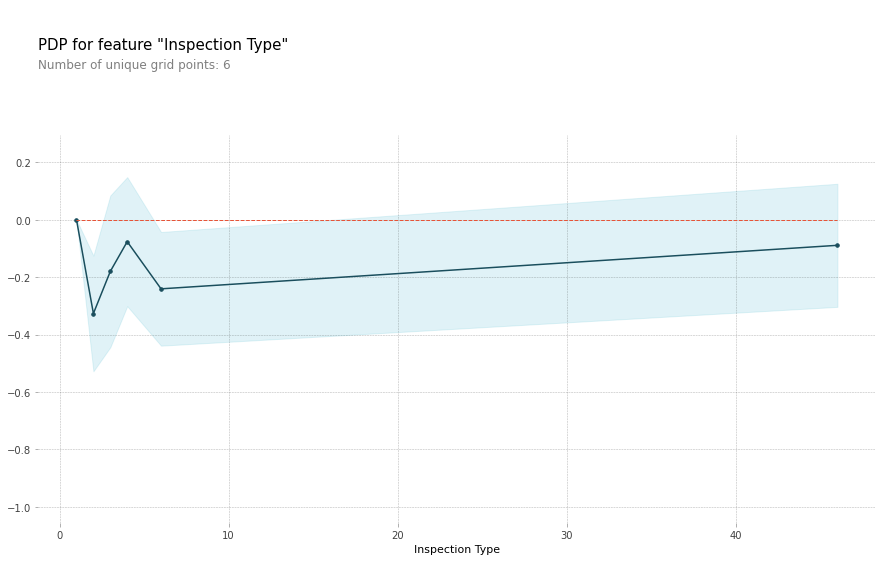

In [107]:
feature = 'Inspection Type'
features = X_train.columns
pdp_dist = pdp.pdp_isolate(model=model2, 
                           dataset=X_encoded, 
                           model_features = features,
                           feature = feature)

pdp.pdp_plot(pdp_dist, feature);

#Stretch goals

To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections.

In [0]:
s_train = pd.read_csv(train_url)
s_test  = pd.read_csv(test_url)

In [109]:
#find the ROC AUC score with all features
#replaces nan's with 'unknown'
s_train = train.fillna('unknown')
s_test = test.fillna('unknown')
s_train.isna().sum(), s_test.isna().sum()

(DBA Name           0
 Facility Type      0
 Risk               0
 City               0
 State              0
 Zip                0
 Inspection Date    0
 Inspection Type    0
 Violations         0
 Latitude           0
 Longitude          0
 Fail               0
 dtype: int64, DBA Name           0
 Facility Type      0
 Risk               0
 City               0
 State              0
 Zip                0
 Inspection Date    0
 Inspection Type    0
 Violations         0
 Latitude           0
 Longitude          0
 Fail               0
 dtype: int64)

In [110]:
s_train, s_val = train_test_split(s_train, train_size = .8, test_size = .2,
                              random_state = 42)
s_train.shape, s_val.shape

((33225, 12), (8307, 12))

In [0]:
X_s_train = s_train.drop(columns = target)
y_s_train = s_train[target]
X_s_val = s_val.drop(columns = target)
y_s_val = s_val[target]
X_s_test = s_test.drop(columns = target)
y_s_test = s_test[target]

In [112]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=100, n_jobs= -1, random_state=42)
)

pipeline.fit(X_s_train, y_s_train)
print(f'Valdiation accuracy: {pipeline.score(X_s_val, y_s_val)}')

Valdiation accuracy: 0.7437101239918141


In [113]:
features = X_s_train.columns
features

Index(['DBA Name', 'Facility Type', 'Risk', 'City', 'State', 'Zip',
       'Inspection Date', 'Inspection Type', 'Violations', 'Latitude',
       'Longitude'],
      dtype='object')